# Plant Disease Classification using Transfer Learning

This notebook demonstrates a plant disease classification task using various deep learning models with transfer learning. The goal is to classify plant leaf images into different disease categories or 'healthy'. We will explore and compare the performance of EfficientNetV2B0, ResNet50V2, MobileNetV3Large, and a Vision Transformer (ViT) model.

## 1. Environment Setup and Library Imports

This section handles necessary library imports and configuration settings, including setting the Keras backend and cache directory for pre-trained models.


In [63]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image

import keras_hub
from tensorflow import keras
from tensorflow.keras import layers, mixed_precision, regularizers

from google.colab import files
import zipfile
import io

from tensorflow.keras import layers, regularizers
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import MobileNetV3Large
from keras.src.losses import loss

## 2. Data Loading and Extraction

First, we load the dataset, which is provided as a `zip` archive, and extract its contents. This dataset contains images of plant leaves categorized by species and disease.

In [65]:
content = files.upload()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [66]:
zip_buffer = io.BytesIO(content)

# 2. Open the zip file from the buffer
with zipfile.ZipFile(zip_buffer) as z:
    # 3. Specify the directory where you want to extract the files
    extraction_path = './Plant Dataset'
    os.makedirs(extraction_path, exist_ok=True)

    # 4. Extract all contents to the specified path
    z.extractall(extraction_path)
    print(f"Extraction to {extraction_path} complete.")

Extraction to ./Plant Dataset complete.


In [67]:
print(os.listdir('./Plant Dataset/Plant Village Dataset/'))

['Val', 'Test', 'Train']


## 3. Data Preparation and Augmentation

Here, we define parameters for image processing and create data generators for training, validation, and testing. Data augmentation is applied to the training set to improve model generalization.

In [68]:
IMG_SIZE = 224
BATCH_SIZE = 16  # Optimized batch size from your experiments
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE
DATA_PATH_TRAIN = 'Plant Dataset/Plant Village Dataset/Train'
DATA_PATH_TEST = 'Plant Dataset/Plant Village Dataset/Test'
DATA_PATH_VAL = 'Plant Dataset/Plant Village Dataset/Val'

In [70]:
# Caching the keras memory to a directory for better performance

# Creating a directory
cache_dir = os.path.abspath('./keras_cache')
os.makedirs(cache_dir, exist_ok=True)

# Set the correct environment variable for KerasHub
os.environ['KERAS_HOME'] = cache_dir

# 3. Verify the change
print(f"KerasHub will now cache models in: {os.environ['KERAS_HOME']}")


KerasHub will now cache models in: /export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_gpu_py3_aditiparekatt.kernel.aditiparekatt.3786887526252.14b334fb3717c109/mount/keras_cache


## EfficientNetV2B0 Model Training

We will train the EfficientNetV2B0 model using transfer learning. The process will involve two main phases:

1.  **Phase 1: Feature Extraction (Warm-up)**: The pre-trained EfficientNetV2B0 base will be frozen, and only the newly added classification head will be trained. This allows the model to learn the specific features of our dataset without altering the powerful pre-trained weights.
2.  **Phase 2: Fine-tuning**: After the warm-up, a portion of the EfficientNetV2B0 base will be unfrozen, and the entire model will be fine-tuned with a very low learning rate. This helps in adapting the pre-trained features more closely to the plant disease classification task.

In [72]:
# Enable mixed precision for faster training on supported GPUs
mixed_precision.set_global_policy('mixed_float16')

# Data Augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(factor=0.2),
    layers.RandomBrightness(factor=0.2)
])

# Prepare Dataset Function
def prepare_dataset(directory, img_size=IMG_SIZE, batch_size=BATCH_SIZE, augment=False):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        seed=SEED,
        image_size=(img_size, img_size),
        batch_size=batch_size,
        label_mode='categorical'
    )

    class_names = ds.class_names

    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)

    ds = ds.cache().prefetch(buffer_size=AUTOTUNE)
    return ds, class_names

# Prepare Datasets and Define Class Information
print(f"Preparing datasets with IMG_SIZE={IMG_SIZE} and BATCH_SIZE={BATCH_SIZE}")

train_ds, train_class_names = prepare_dataset('Plant Dataset/Plant Village Dataset/Train', augment=True)
test_ds, _ = prepare_dataset('Plant Dataset/Plant Village Dataset/Test', augment=False)
val_ds, _ = prepare_dataset('Plant Dataset/Plant Village Dataset/Val', augment=False)


class_names = train_class_names # class names from the training dataset
num_classes = len(class_names)

print(f"Successfully prepared training and test datasets.")
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

Preparing datasets with IMG_SIZE=224 and BATCH_SIZE=16
Found 53693 files belonging to 29 classes.
Found 1358 files belonging to 29 classes.
Found 12067 files belonging to 29 classes.
Successfully prepared training and test datasets.
Number of classes: 29
Class names: ['Apple - Apple Scab', 'Apple - Black Rot', 'Apple - Cedar Apple Rust', 'Apple - Healthy', 'Bell Pepper - Bacterial Spot', 'Bell Pepper - Healthy', 'Cherry - Healthy', 'Cherry - Powdery Mildew', 'Corn (Maize) - Cercospora Leaf Spot', 'Corn (Maize) - Common Rust', 'Corn (Maize) - Healthy', 'Corn (Maize) - Northern Leaf Blight', 'Grape - Black Rot', 'Grape - Esca (Black Measles)', 'Grape - Healthy', 'Grape - Leaf Blight', 'Peach - Bacterial Spot', 'Peach - Healthy', 'Potato - Early Blight', 'Potato - Healthy', 'Potato - Late Blight', 'Strawberry - Healthy', 'Strawberry - Leaf Scorch', 'Tomato - Bacterial Spot', 'Tomato - Early Blight', 'Tomato - Healthy', 'Tomato - Late Blight', 'Tomato - Septoria Leaf Spot', 'Tomato - Yello

In [73]:
# Building the Efficientnet Model Function

def build_efficientnet_model(num_classes, img_size=IMG_SIZE):
    base = EfficientNetV2B0(include_top=False,
                            input_shape=(img_size, img_size, 3),
                            weights='imagenet')
    base.trainable = False  # Initially freeze backbone

    inputs = keras.Input(shape=(img_size, img_size, 3))
    x = base(inputs, training=False) # Ensuring base runs in inference mode during initial freeze
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)

    # L2 Regularization added to the final layer to prevent overfitting
    outputs = layers.Dense(
        num_classes,
        activation='softmax',
        dtype='float32',
        kernel_regularizer=regularizers.l2(0.001)
    )(x)

    return keras.Model(inputs, outputs)

In [75]:
model_effnet = build_efficientnet_model(num_classes=num_classes, img_size=IMG_SIZE)
print("EfficientNetV2B0 Model built successfully!")

EfficientNetV2B0 Model built successfully!


In [76]:
print("---- Phase 1: Training top layers only (EfficientNetV2B0) ----")
model_effnet.compile(optimizer=keras.optimizers.Adam(5e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history1_effnet = model_effnet.fit(train_ds, validation_data=val_ds, epochs=2)

---- Phase 1: Training top layers only (EfficientNetV2B0) ----
Epoch 1/2
3356/3356 [==============================] - 140s 38ms/step - loss: 0.7956 - accuracy: 0.8508 - val_loss: 0.4330 - val_accuracy: 0.9418
Epoch 2/2
3356/3356 [==============================] - 37s 11ms/step - loss: 0.4755 - accuracy: 0.9289 - val_loss: 0.3955 - val_accuracy: 0.9499


In [77]:
# EfficientNetV2B0 is the second layer after Input
base_model_effnet = model_effnet.layers[1]
base_model_effnet.trainable = True

# Freeze all but the last 20 layers of the backbone
for layer in base_model_effnet.layers[:-20]:
    layer.trainable = False

model_effnet.compile(optimizer=keras.optimizers.Adam(5e-6),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history2_effnet = model_effnet.fit(train_ds, validation_data=val_ds, epochs=6)

Epoch 1/6
3356/3356 [==============================] - 63s 15ms/step - loss: 0.3832 - accuracy: 0.9391 - val_loss: 0.3062 - val_accuracy: 0.9605
Epoch 2/6
3356/3356 [==============================] - 43s 13ms/step - loss: 0.3468 - accuracy: 0.9477 - val_loss: 0.2906 - val_accuracy: 0.9656
Epoch 3/6
3356/3356 [==============================] - 43s 13ms/step - loss: 0.3268 - accuracy: 0.9518 - val_loss: 0.2803 - val_accuracy: 0.9677
Epoch 4/6
3356/3356 [==============================] - 44s 13ms/step - loss: 0.3101 - accuracy: 0.9563 - val_loss: 0.2719 - val_accuracy: 0.9693
Epoch 5/6
3356/3356 [==============================] - 42s 13ms/step - loss: 0.2960 - accuracy: 0.9603 - val_loss: 0.2626 - val_accuracy: 0.9716
Epoch 6/6
3356/3356 [==============================] - 43s 13ms/step - loss: 0.2846 - accuracy: 0.9634 - val_loss: 0.2559 - val_accuracy: 0.9728


### EfficientNetV2B0 Prediction and Evaluation

After training, we will evaluate the EfficientNetV2B0 model on the test dataset to assess its generalization capabilities. This involves calculating the test loss and accuracy, generating a confusion matrix, and a classification report to understand the model's performance across all classes.

In [79]:
loss_effnet, acc_effnet = model_effnet.evaluate(test_ds)
print(f"Test Accuracy: {acc_effnet*100:.2f}%")
print(f"Test Loss: {loss_effnet:.4f}")

85/85 [==============================] - 1s 10ms/step - loss: 0.2554 - accuracy: 0.9764
Test Accuracy: 97.64%
Test Loss: 0.2554


In [80]:
# Combine training histories for later visualization
train_accuracy_effnet = history1_effnet.history['accuracy'] + history2_effnet.history['accuracy']
val_accuracy_effnet = history1_effnet.history['val_accuracy'] + history2_effnet.history['val_accuracy']
train_loss_effnet = history1_effnet.history['loss'] + history2_effnet.history['loss']
val_loss_effnet = history1_effnet.history['val_loss'] + history2_effnet.history['val_loss']

print("EfficientNetV2B0 training complete and histories combined.")

EfficientNetV2B0 training complete and histories combined.


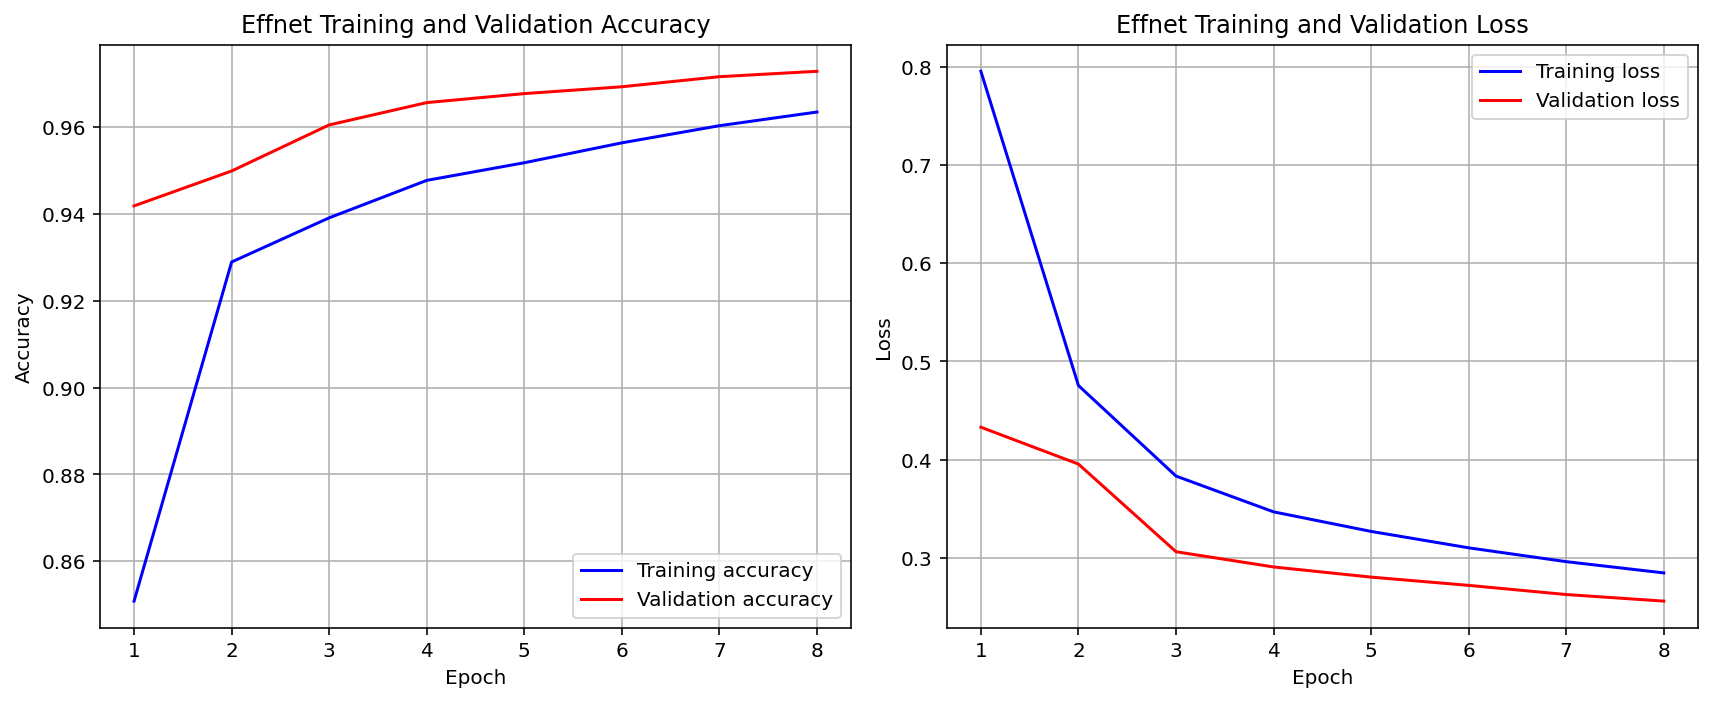

In [82]:
# Determine the total number of epochs for MobileNetV3Large
epochs_effnet = range(1, len(train_accuracy_effnet) + 1)


# Plot Training and Validation Accuracy for MobileNetV3Large
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.plot(epochs_effnet, train_accuracy_effnet, 'b', label='Training accuracy')
plt.plot(epochs_effnet, val_accuracy_effnet, 'r', label='Validation accuracy')
plt.title('Effnet Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


# Plot Training and Validation Loss for MobileNetV3Large
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
plt.plot(epochs_effnet, train_loss_effnet, 'b', label='Training loss')
plt.plot(epochs_effnet, val_loss_effnet, 'r', label='Validation loss')
plt.title('Effnet Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

85/85 [==============================] - 2s 8ms/step


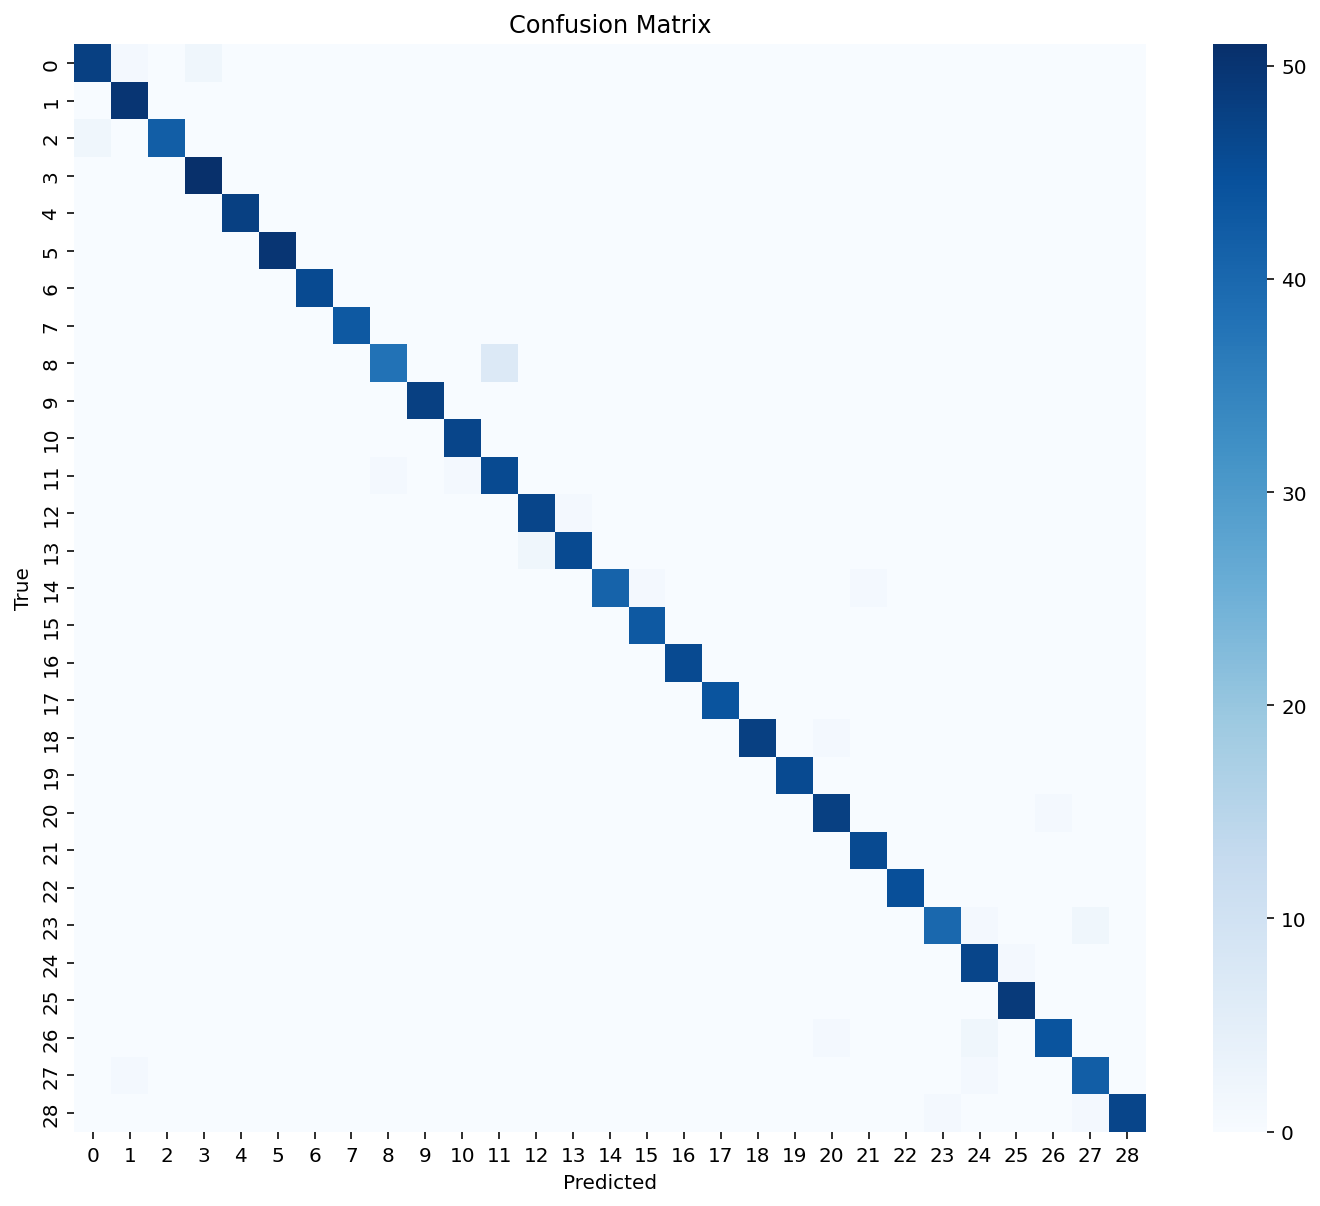

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.94      0.95        51
           1       0.96      1.00      0.98        50
           2       1.00      0.95      0.98        44
           3       0.96      1.00      0.98        51
           4       1.00      1.00      1.00        48
           5       1.00      1.00      1.00        50
           6       1.00      1.00      1.00        46
           7       1.00      1.00      1.00        43
           8       0.97      0.84      0.90        45
           9       1.00      1.00      1.00        48
          10       0.98      1.00      0.99        47
          11       0.87      0.96      0.91        48
          12       0.96      0.98      0.97        48
          13       0.98      0.96      0.97        48
          14       1.00      0.95      0.98        43
          15       0.98      1.00      0.99        43
          16       1.00      1.00      1.00        46
   

In [84]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true_labels = np.argmax(y_true, axis=1)

y_pred = model_effnet.predict(test_ds)
y_pred_labels = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(y_true_labels, y_pred_labels))

## ResNet50V2 Model Training

The ResNet50V2 model will also be trained using a two-phase transfer learning strategy:

1.  **Phase 1: Feature Extraction (Warm-up)**: The pre-trained ResNet50V2 base will be frozen, and the custom classification head built on top of it will be trained. This initial training helps stabilize the new layers.
2.  **Phase 2: Fine-tuning**: Following the warm-up, the latter layers of the ResNet50V2 base will be unfrozen. The model will then undergo fine-tuning with a reduced learning rate to optimize its performance on the plant disease dataset.

In [85]:
# Building the ResNet Model Function

def build_resnet_model(num_classes, img_size=IMG_SIZE):
    base = ResNet50V2(include_top=False,
                      weights='imagenet',
                      input_shape=(img_size, img_size, 3))
    base.trainable = False  # Initially freeze backbone

    inputs = keras.Input(shape=(img_size, img_size, 3))
    x = base(inputs, training=False) # Ensuring base runs in inference mode during initial freeze
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32',
                           kernel_regularizer=regularizers.l2(0.001))(x)

    return keras.Model(inputs, outputs)


In [86]:
model_resnet = build_resnet_model(num_classes=num_classes, img_size=IMG_SIZE)
print("ResNet50V2 Model built successfully!")

ResNet50V2 Model built successfully!


In [87]:
print("---- Phase 1: Training top layers only (ResNet50V2) ----")
model_resnet.compile(optimizer=keras.optimizers.Adam(5e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history1_resnet = model_resnet.fit(train_ds, validation_data=test_ds, epochs=2)


---- Phase 1: Training top layers only (ResNet50V2) ----
Epoch 1/2
3356/3356 [==============================] - 46s 13ms/step - loss: 42.7087 - accuracy: 0.1905 - val_loss: 23.5158 - val_accuracy: 0.2518
Epoch 2/2
3356/3356 [==============================] - 42s 13ms/step - loss: 18.1028 - accuracy: 0.2706 - val_loss: 21.2535 - val_accuracy: 0.2842


In [88]:
# --- PHASE 2: Gradual Unfreezing ---
print("---- Phase 2: Fine-tuning last 20 layers (ResNet50V2) ----")

# The base model is the second layer in our functional API model
base_model_resnet = model_resnet.layers[1]
base_model_resnet.trainable = True

# Freeze all but the last 20 layers of the backbone
for layer in base_model_resnet.layers[:-20]:
    layer.trainable = False

model_resnet.compile(optimizer=keras.optimizers.Adam(5e-6),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history2_resnet = model_resnet.fit(train_ds, validation_data=test_ds, epochs=6)


---- Phase 2: Fine-tuning last 20 layers (ResNet50V2) ----
Epoch 1/6
3356/3356 [==============================] - 69s 18ms/step - loss: 4.6484 - accuracy: 0.3636 - val_loss: 3.6809 - val_accuracy: 0.3719
Epoch 2/6
3356/3356 [==============================] - 55s 17ms/step - loss: 1.8687 - accuracy: 0.4795 - val_loss: 2.9761 - val_accuracy: 0.3888
Epoch 3/6
3356/3356 [==============================] - 55s 16ms/step - loss: 1.6105 - accuracy: 0.5430 - val_loss: 2.9115 - val_accuracy: 0.3976
Epoch 4/6
3356/3356 [==============================] - 55s 17ms/step - loss: 1.4668 - accuracy: 0.5817 - val_loss: 2.8125 - val_accuracy: 0.4094
Epoch 5/6
3356/3356 [==============================] - 55s 16ms/step - loss: 1.3532 - accuracy: 0.6122 - val_loss: 2.6675 - val_accuracy: 0.4256
Epoch 6/6
3356/3356 [==============================] - 54s 16ms/step - loss: 1.2667 - accuracy: 0.6357 - val_loss: 2.9334 - val_accuracy: 0.4138


### ResNet50V2 Prediction and Evaluation

Similar to EfficientNetV2B0, we will evaluate the ResNet50V2 model's performance on the test set. This section will present the test accuracy, loss, confusion matrix, and classification report to provide a comprehensive view of the model's predictive accuracy for each plant disease category.

In [97]:
loss_resnet, acc_resnet = model_resnet.evaluate(test_ds)
print(f"Test Accuracy: {acc_resnet*100:.2f}%")
print(f"Test Loss: {loss_resnet:.4f}")

85/85 [==============================] - 1s 14ms/step - loss: 2.9334 - accuracy: 0.4138
Test Accuracy: 41.38%
Test Loss: 2.9334


In [90]:
# Combine training histories for later visualization
train_accuracy_resnet = history1_resnet.history['accuracy'] + history2_resnet.history['accuracy']
val_accuracy_resnet = history1_resnet.history['val_accuracy'] + history2_resnet.history['val_accuracy']
train_loss_resnet = history1_resnet.history['loss'] + history2_resnet.history['loss']
val_loss_resnet = history1_resnet.history['val_loss'] + history2_resnet.history['val_loss']


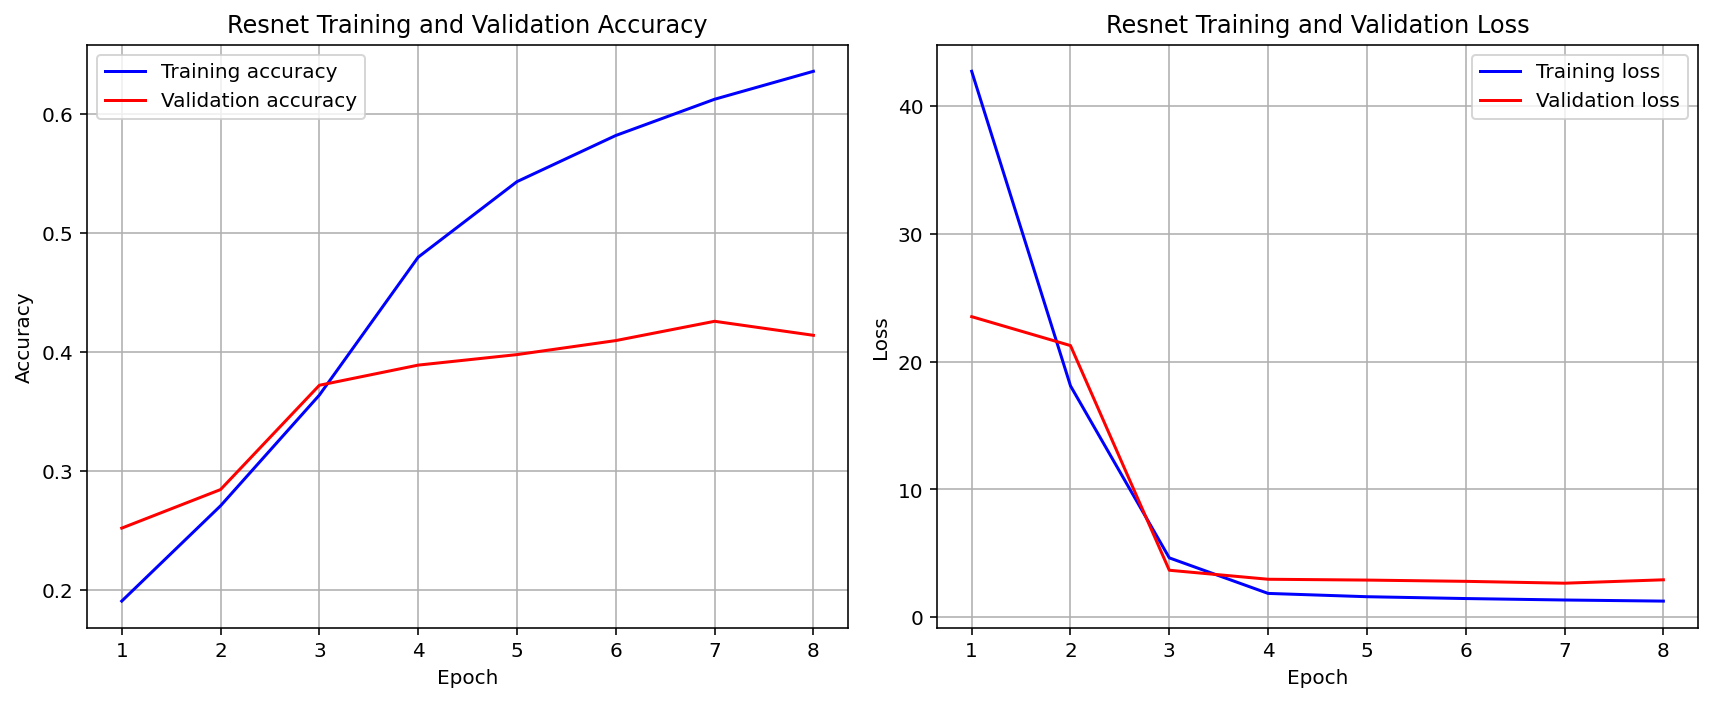

In [91]:
# Determine the total number of epochs for MobileNetV3Large
epochs_resnet = range(1, len(train_accuracy_resnet) + 1)


# Plot Training and Validation Accuracy for MobileNetV3Large
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.plot(epochs_resnet, train_accuracy_resnet, 'b', label='Training accuracy')
plt.plot(epochs_resnet, val_accuracy_resnet, 'r', label='Validation accuracy')
plt.title('Resnet Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


# Plot Training and Validation Loss for MobileNetV3Large
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
plt.plot(epochs_resnet, train_loss_resnet, 'b', label='Training loss')
plt.plot(epochs_resnet, val_loss_resnet, 'r', label='Validation loss')
plt.title('Resnet Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

85/85 [==============================] - 1s 12ms/step


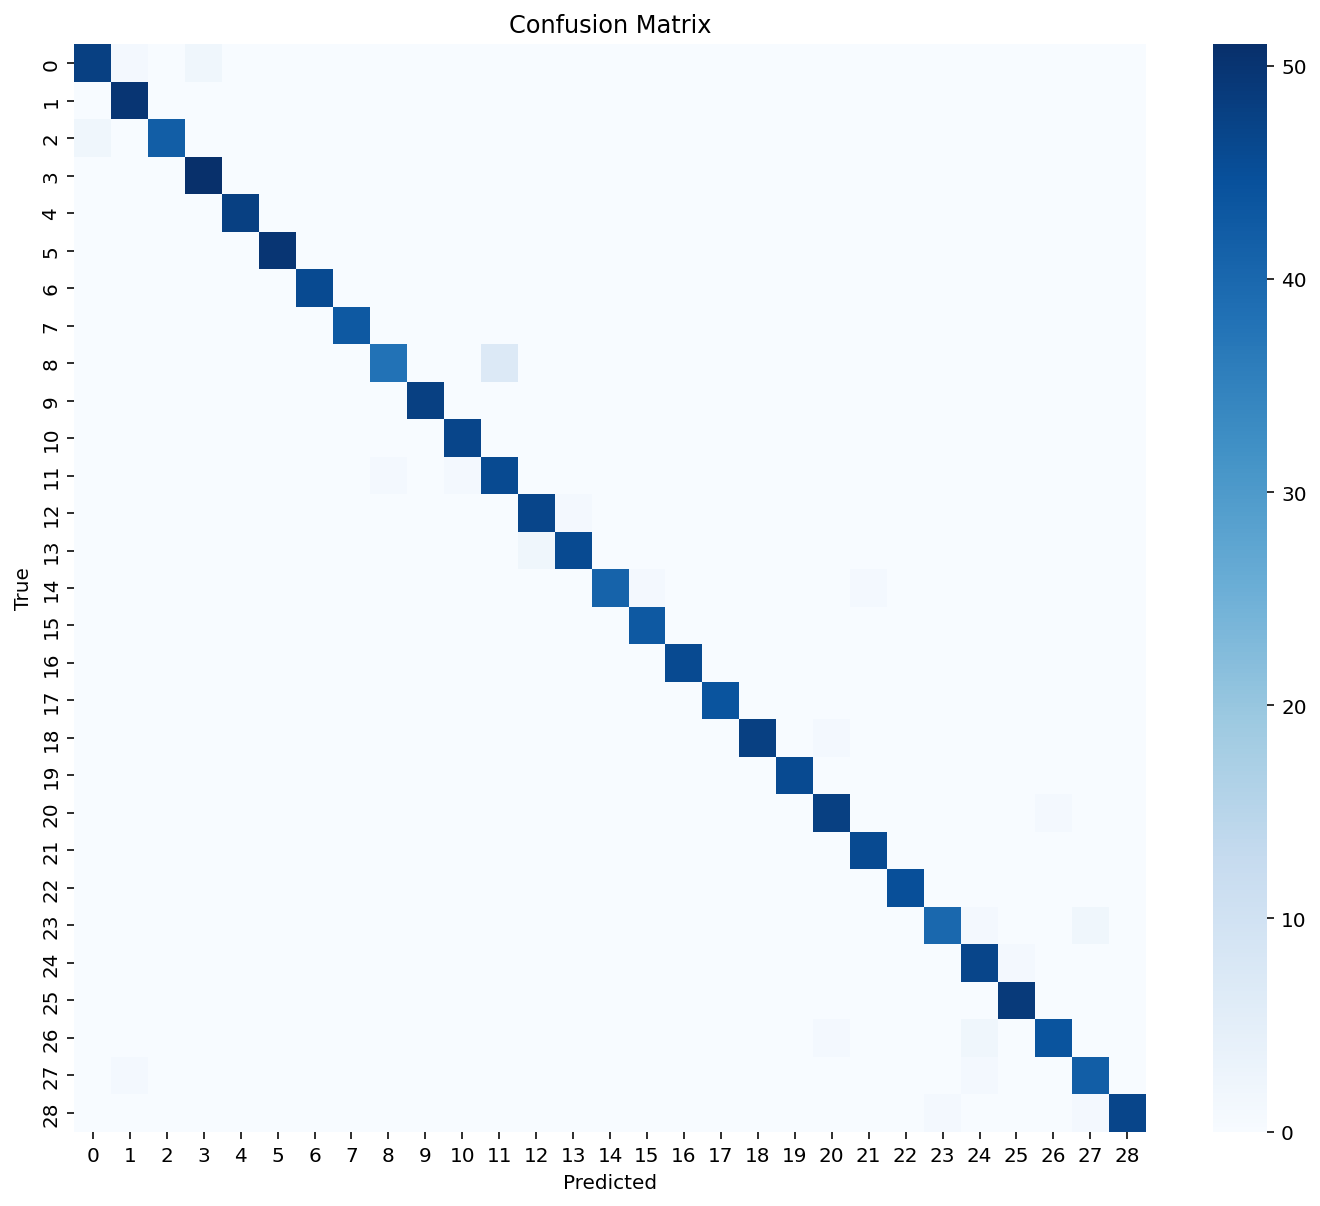

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.94      0.95        51
           1       0.96      1.00      0.98        50
           2       1.00      0.95      0.98        44
           3       0.96      1.00      0.98        51
           4       1.00      1.00      1.00        48
           5       1.00      1.00      1.00        50
           6       1.00      1.00      1.00        46
           7       1.00      1.00      1.00        43
           8       0.97      0.84      0.90        45
           9       1.00      1.00      1.00        48
          10       0.98      1.00      0.99        47
          11       0.87      0.96      0.91        48
          12       0.96      0.98      0.97        48
          13       0.98      0.96      0.97        48
          14       1.00      0.95      0.98        43
          15       0.98      1.00      0.99        43
          16       1.00      1.00      1.00        46
   

In [96]:
y_true_resnet = np.concatenate([y for x, y in test_ds], axis=0)
y_true_labels_resnet = np.argmax(y_true_resnet, axis=1)

y_pred_resnet = model_resnet.predict(test_ds)
y_pred_labels_resnet = np.argmax(y_pred, axis=1)

# Confusion matrix
cm_resnet = confusion_matrix(y_true_labels_resnet, y_pred_labels_resnet)

plt.figure(figsize=(12,10))
sns.heatmap(cm_resnet, annot=False, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(y_true_labels_resnet, y_pred_labels_resnet))

## MobileNetV3Large Model Training

Similar to the other models, MobileNetV3Large will be trained in two phases:

1.  **Phase 1: Feature Extraction (Warm-up)**: The pre-trained MobileNetV3Large base model layers will be frozen, and only the newly added top classification layers will be trained. This step quickly adapts the model to the output space of our dataset.
2.  **Phase 2: Fine-tuning**: After the initial training, the MobileNetV3Large base will be partially unfrozen, and the entire model will be fine-tuned with a very small learning rate. This allows for subtle adjustments to the feature extraction capabilities of the base model.

In [98]:
# Building the MobileNet Model Function
def build_mobilenet_model(num_classes, img_size=IMG_SIZE):
    base = MobileNetV3Large(include_top=False,
                            weights='imagenet',
                            input_shape=(img_size, img_size, 3))
    base.trainable = False  # Initially freeze backbone

    inputs = keras.Input(shape=(img_size, img_size, 3))
    x = base(inputs, training=False) # Ensuring base runs in inference mode during initial freeze
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(
        num_classes, activation='softmax', dtype='float32',
        kernel_regularizer=regularizers.l2(0.001)
    )(x)

    return keras.Model(inputs, outputs)


In [99]:
model_mobilenet = build_mobilenet_model(num_classes=num_classes, img_size=IMG_SIZE)
print("MobileNetV3Large Model built successfully!")

MobileNetV3Large Model built successfully!


In [100]:
# --- PHASE 1: Warm-up ---
print("---- Phase 1: Training top layers only (MobileNetV3Large) ----")
model_mobilenet.compile(optimizer=keras.optimizers.Adam(5e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history1_mobilenet = model_mobilenet.fit(train_ds, validation_data=test_ds, epochs=2)


---- Phase 1: Training top layers only (MobileNetV3Large) ----
Epoch 1/2
3356/3356 [==============================] - 85s 21ms/step - loss: 0.7603 - accuracy: 0.8174 - val_loss: 0.3028 - val_accuracy: 0.9411
Epoch 2/2
3356/3356 [==============================] - 41s 12ms/step - loss: 0.3798 - accuracy: 0.9243 - val_loss: 0.2694 - val_accuracy: 0.9536


In [101]:
# --- PHASE 2: Gradual Unfreezing ---
print("---- Phase 2: Fine-tuning last 20 layers (MobileNetV3Large) ----")

# The base model is the second layer in our functional API model
base_model_mobilenet = model_mobilenet.layers[1]
base_model_mobilenet.trainable = True

# Freeze all but the last 20 layers of the backbone
for layer in base_model_mobilenet.layers[:-20]:
    layer.trainable = False

model_mobilenet.compile(optimizer=keras.optimizers.Adam(5e-6),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history2_mobilenet = model_mobilenet.fit(train_ds, validation_data=test_ds, epochs=6)


---- Phase 2: Fine-tuning last 20 layers (MobileNetV3Large) ----
Epoch 1/6
3356/3356 [==============================] - 50s 14ms/step - loss: 0.2944 - accuracy: 0.9405 - val_loss: 0.2087 - val_accuracy: 0.9632
Epoch 2/6
3356/3356 [==============================] - 46s 14ms/step - loss: 0.2645 - accuracy: 0.9477 - val_loss: 0.1976 - val_accuracy: 0.9654
Epoch 3/6
3356/3356 [==============================] - 46s 14ms/step - loss: 0.2457 - accuracy: 0.9548 - val_loss: 0.1900 - val_accuracy: 0.9676
Epoch 4/6
3356/3356 [==============================] - 45s 13ms/step - loss: 0.2344 - accuracy: 0.9578 - val_loss: 0.1847 - val_accuracy: 0.9698
Epoch 5/6
3356/3356 [==============================] - 46s 14ms/step - loss: 0.2257 - accuracy: 0.9608 - val_loss: 0.1777 - val_accuracy: 0.9705
Epoch 6/6
3356/3356 [==============================] - 46s 14ms/step - loss: 0.2183 - accuracy: 0.9628 - val_loss: 0.1754 - val_accuracy: 0.9705


### MobileNetV3Large Prediction and Evaluation

Here, we assess the MobileNetV3Large model on the held-out test dataset. We will report the test loss and accuracy, and visualize its classification performance using a confusion matrix and a detailed classification report, which highlights precision, recall, and F1-score for each class.

In [133]:
loss_mobilenet, acc_mobilenet = model_mobilenet.evaluate(test_ds)
print(f"Test Accuracy: {acc_mobilenet*100:.2f}%")
print(f"Test Loss: {loss_mobilenet:.4f}")

85/85 [==============================] - 1s 14ms/step - loss: 0.1753 - accuracy: 0.9705
Test Accuracy: 97.05%
Test Loss: 0.1753


In [102]:
train_accuracy_mobilenet = history1_mobilenet.history['accuracy'] + history2_mobilenet.history['accuracy']
val_accuracy_mobilenet = history1_mobilenet.history['val_accuracy'] + history2_mobilenet.history['val_accuracy']
train_loss_mobilenet = history1_mobilenet.history['loss'] + history2_mobilenet.history['loss']
val_loss_mobilenet = history1_mobilenet.history['val_loss'] + history2_mobilenet.history['val_loss']


In [103]:
print("MobileNetV3Large training complete and histories combined.")

MobileNetV3Large training complete and histories combined.


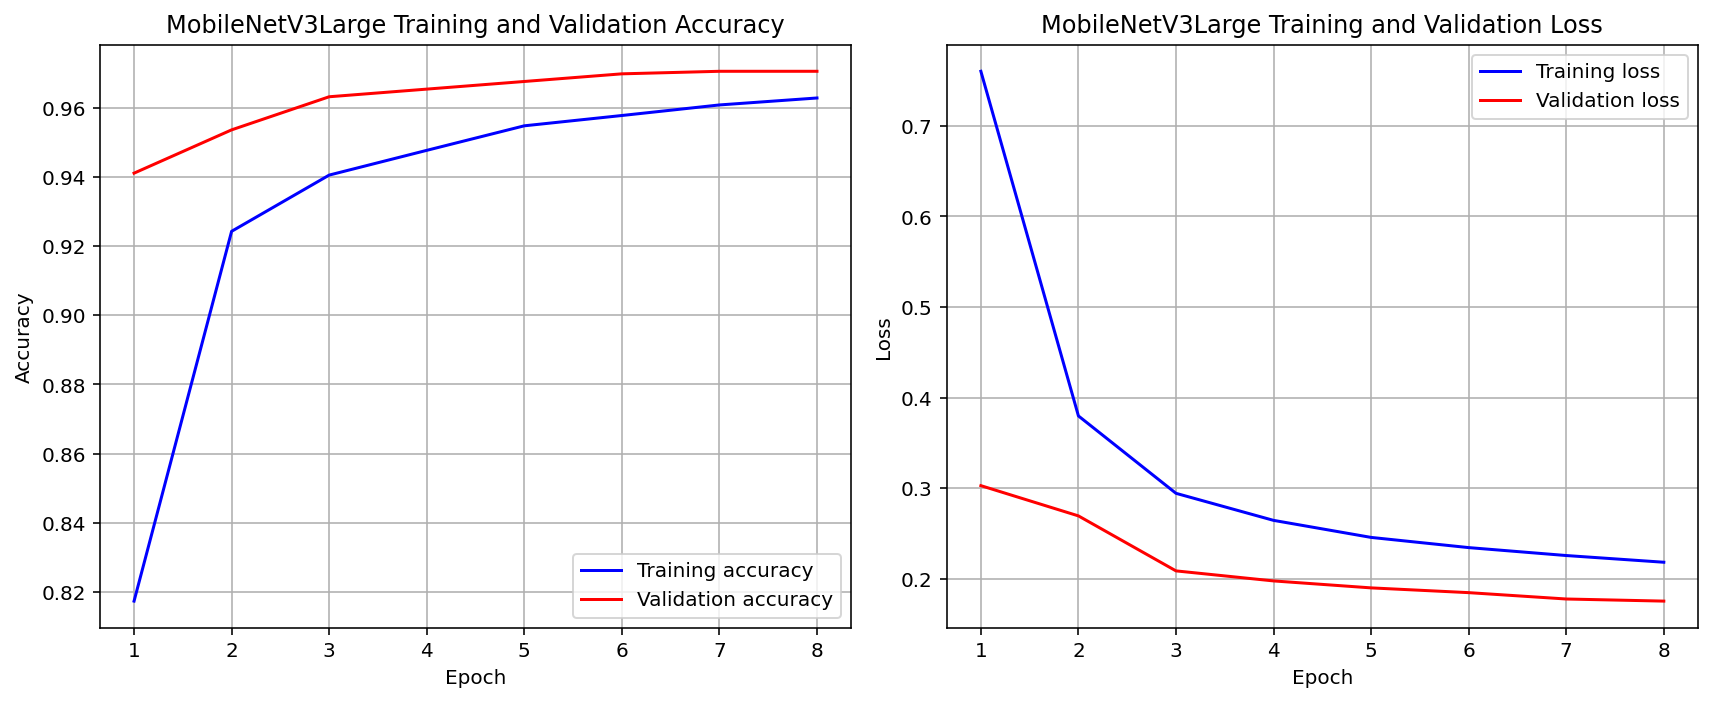

In [104]:
# Determine the total number of epochs for MobileNetV3Large
epochs_mobilenet = range(1, len(train_accuracy_mobilenet) + 1)


# Plot Training and Validation Accuracy for MobileNetV3Large
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.plot(epochs_mobilenet, train_accuracy_mobilenet, 'b', label='Training accuracy')
plt.plot(epochs_mobilenet, val_accuracy_mobilenet, 'r', label='Validation accuracy')
plt.title('MobileNetV3Large Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


# Plot Training and Validation Loss for MobileNetV3Large
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
plt.plot(epochs_mobilenet, train_loss_mobilenet, 'b', label='Training loss')
plt.plot(epochs_mobilenet, val_loss_mobilenet, 'r', label='Validation loss')
plt.title('MobileNetV3Large Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

85/85 [==============================] - 2s 11ms/step


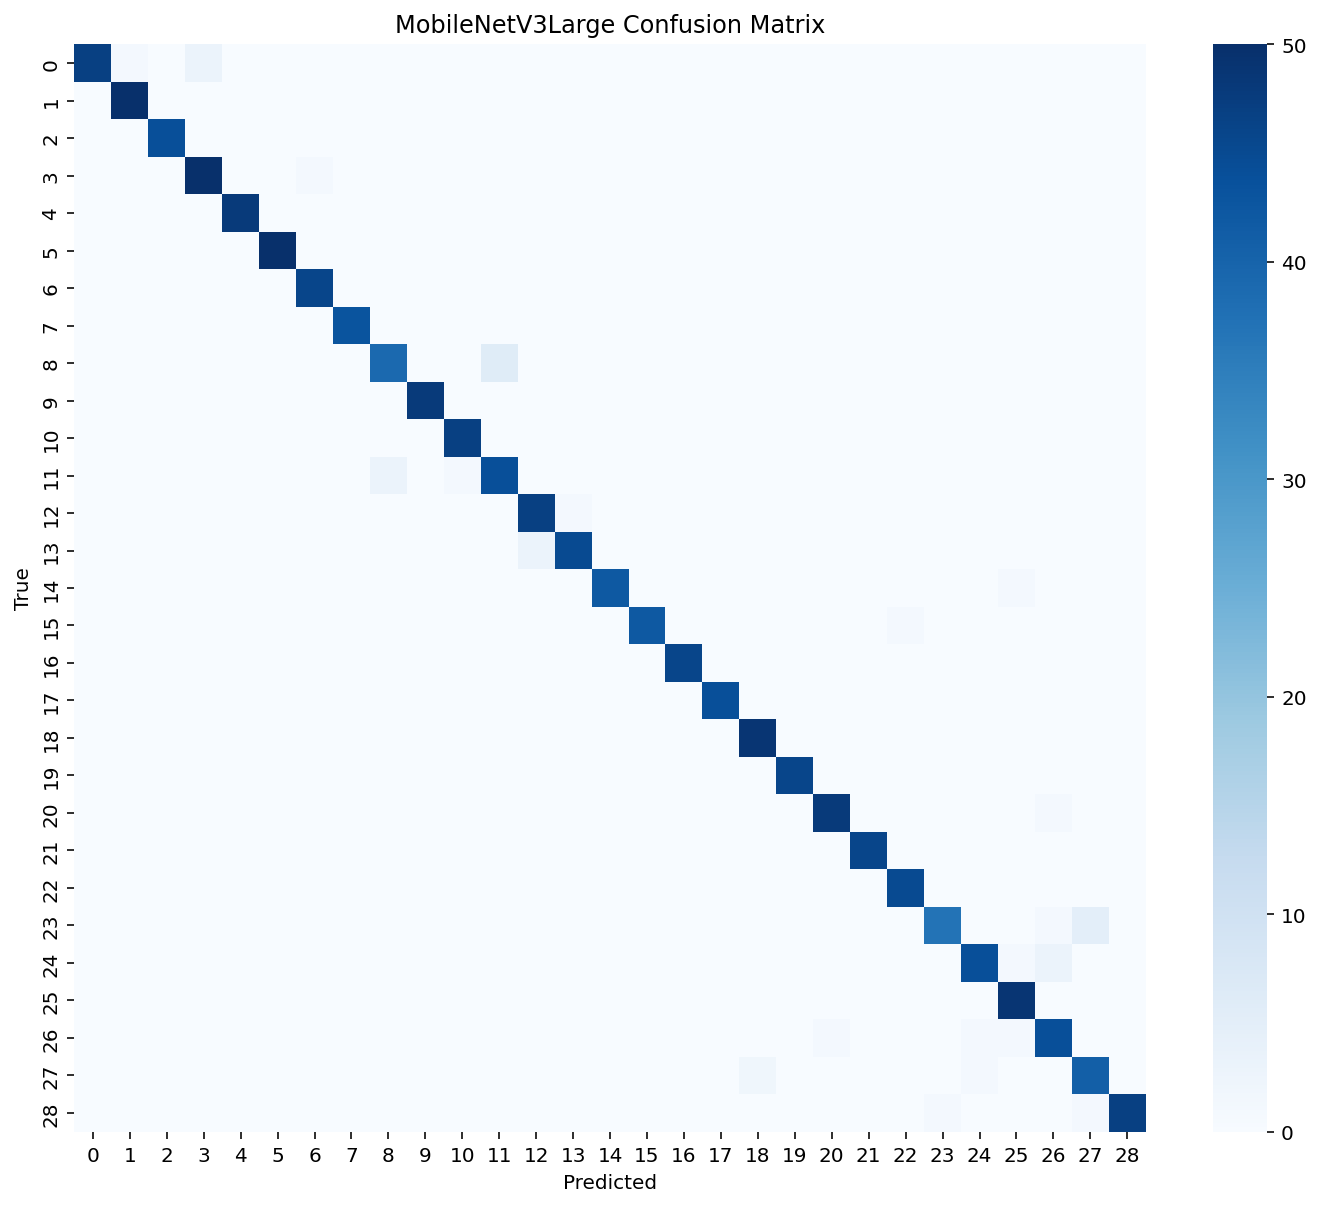

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        51
           1       0.98      1.00      0.99        50
           2       1.00      1.00      1.00        44
           3       0.94      0.98      0.96        51
           4       1.00      1.00      1.00        48
           5       1.00      1.00      1.00        50
           6       0.98      1.00      0.99        46
           7       1.00      1.00      1.00        43
           8       0.93      0.87      0.90        45
           9       1.00      1.00      1.00        48
          10       0.98      1.00      0.99        47
          11       0.88      0.92      0.90        48
          12       0.94      0.98      0.96        48
          13       0.98      0.94      0.96        48
          14       1.00      0.98      0.99        43
          15       1.00      0.98      0.99        43
          16       1.00      1.00      1.00        46
   

In [105]:
y_true_mobilenet = np.concatenate([y for x, y in test_ds], axis=0)
y_true_labels_mobilenet = np.argmax(y_true_mobilenet, axis=1)

y_pred_mobilenet = model_mobilenet.predict(test_ds)
y_pred_labels_mobilenet = np.argmax(y_pred_mobilenet, axis=1)

# Confusion matrix
cm_mobilenet = confusion_matrix(y_true_labels_mobilenet, y_pred_labels_mobilenet)

plt.figure(figsize=(12,10))
sns.heatmap(cm_mobilenet, annot=False, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('MobileNetV3Large Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(y_true_labels_mobilenet, y_pred_labels_mobilenet))

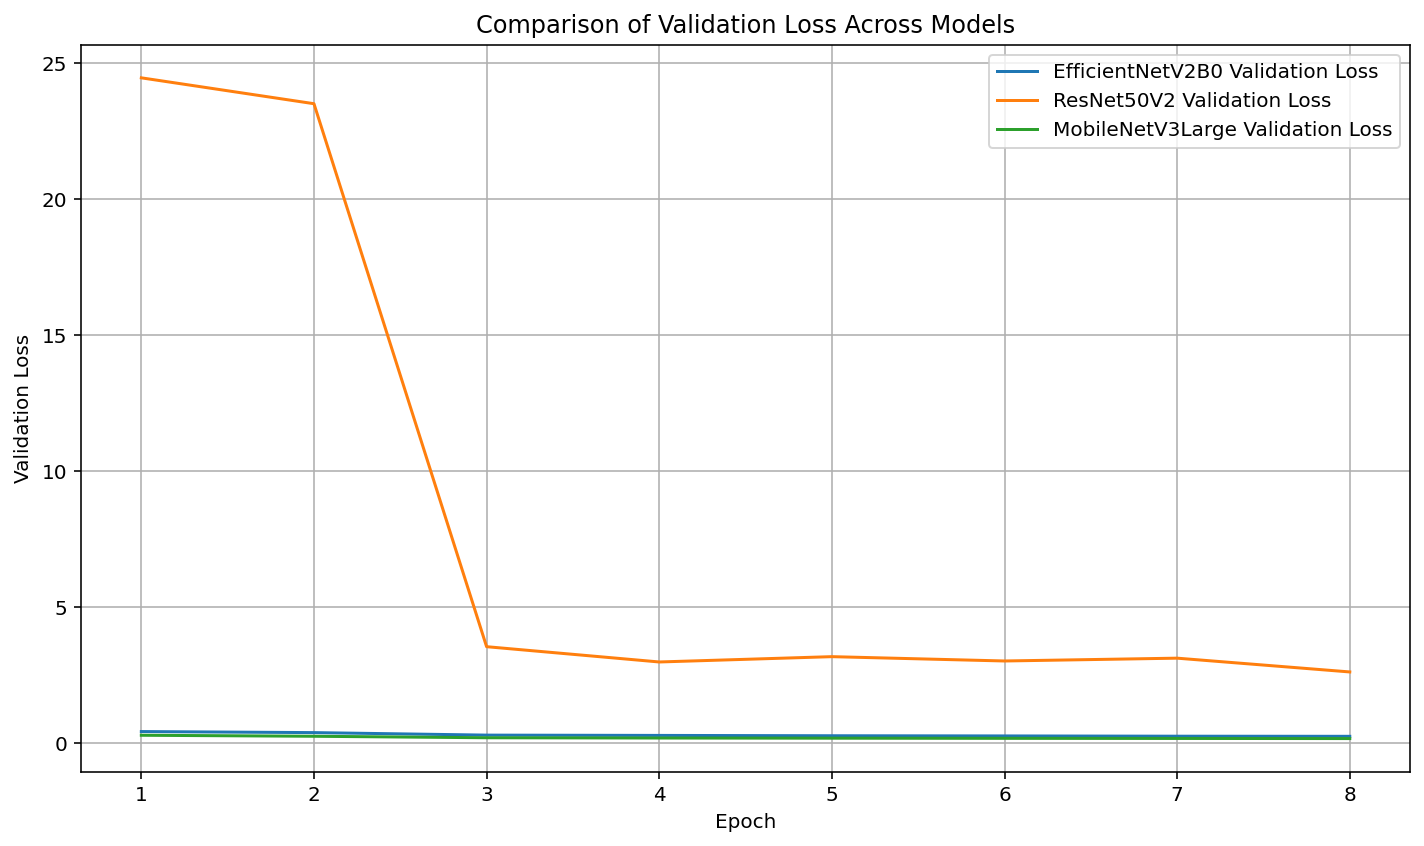

In [63]:


# Determine the total number of epochs (all models trained for 2 + 6 = 8 epochs)
epochs = range(1, len(val_loss_effnet) + 1)

# Create a new figure and an axes object
plt.figure(figsize=(10, 6))

# Plot the validation loss for each model
plt.plot(epochs, val_loss_effnet, label='EfficientNetV2B0 Validation Loss')
plt.plot(epochs, val_loss_resnet, label='ResNet50V2 Validation Loss')
plt.plot(epochs, val_loss_mobilenet, label='MobileNetV3Large Validation Loss')
# plt.plot(epochs, val_loss_vit, label='Vision Transformer Validation Loss')

# Add title, labels, and legend
plt.title('Comparison of Validation Loss Across Models')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)

# Ensure all elements fit within the figure
plt.tight_layout()

# Display the plot
plt.show()


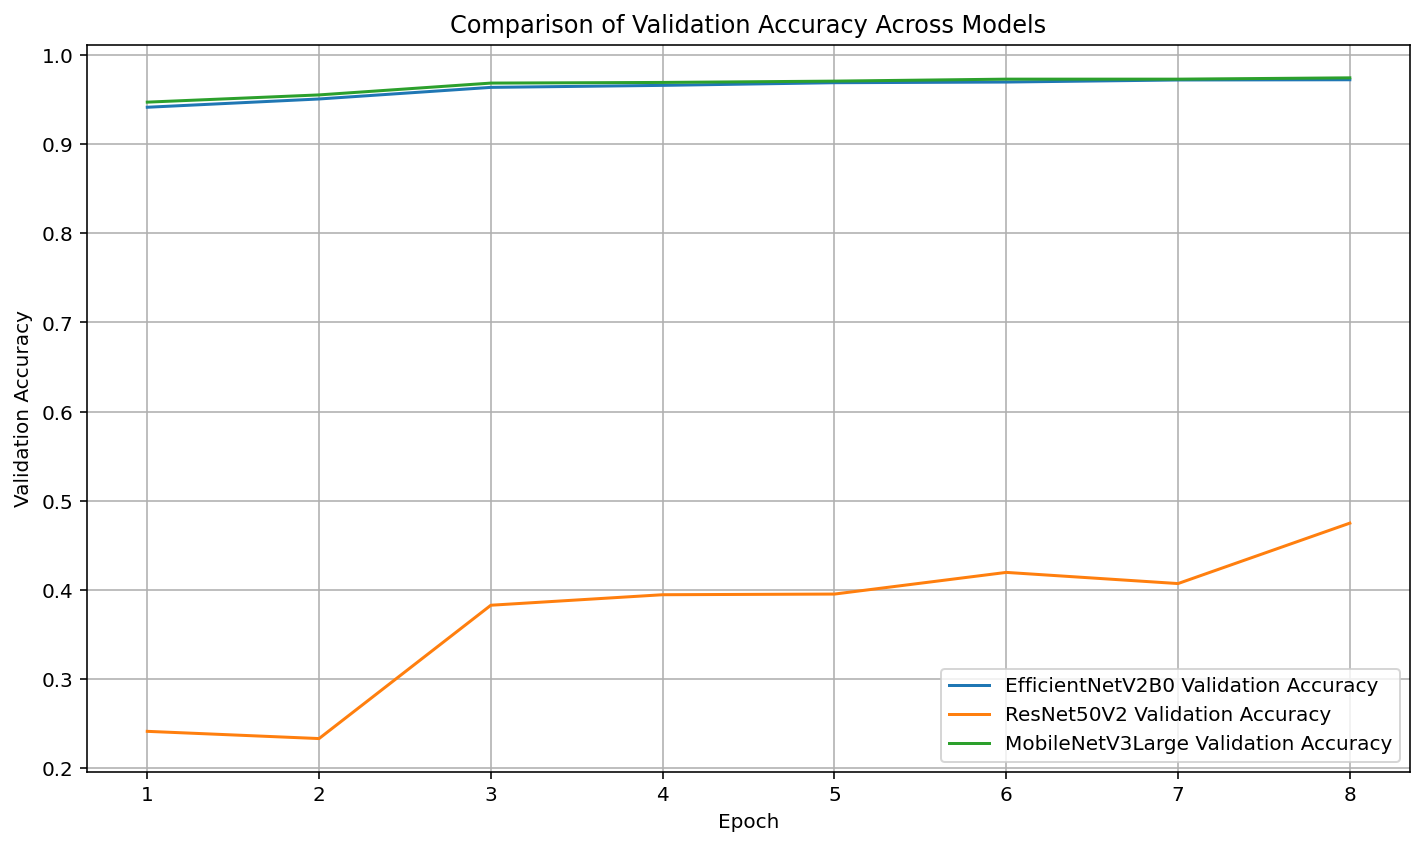

In [65]:
import matplotlib.pyplot as plt

# Determine the total number of epochs (all models trained for 2 + 6 = 8 epochs)
epochs = range(1, len(val_accuracy_effnet) + 1)

# Create a new figure and an axes object
plt.figure(figsize=(10, 6))

# Plot the validation accuracy for each model
plt.plot(epochs, val_accuracy_effnet, label='EfficientNetV2B0 Validation Accuracy')
plt.plot(epochs, val_accuracy_resnet, label='ResNet50V2 Validation Accuracy')
plt.plot(epochs, val_accuracy_mobilenet, label='MobileNetV3Large Validation Accuracy')
# plt.plot(epochs, val_accuracy_vit, label='Vision Transformer Validation Accuracy')

# Add title, labels, and legend
plt.title('Comparison of Validation Accuracy Across Models')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)

# Ensure all elements fit within the figure
plt.tight_layout()

# Display the plot
plt.show()

## Vision Transformer (ViT) Model Training

The Vision Transformer (ViT) model will be trained using transfer learning with a two-step approach:

1.  **Phase 1: Warm-up**: The pre-trained ViT backbone will be kept frozen, and only the newly added MLP head for classification will be trained. This helps in quickly learning the mapping from ViT's feature space to our class labels.
2.  **Phase 2: Fine-tuning**: Subsequently, the entire ViT model, including a portion of its backbone, will be unfrozen and trained with a very low learning rate. This fine-tuning step allows the powerful self-attention mechanisms of ViT to adapt specifically to the visual nuances of the plant disease images.

In [109]:
IMG_SIZE = 224
BATCH_SIZE = 16
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE
DATA_PATH_TRAIN = 'Plant Dataset/Plant Village Dataset/Train'
DATA_PATH_TEST = 'Plant Dataset/Plant Village Dataset/Test'
DATA_PATH_VAL = 'Plant Dataset/Plant Village Dataset/Val'

In [120]:
def prepare_dataset(directory, img_size=IMG_SIZE, batch_size=BATCH_SIZE, augment=False, shuffle=True):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        seed=SEED,
        image_size=(img_size, img_size),
        batch_size=batch_size,
        label_mode='categorical',
        shuffle=shuffle
    )

    if augment:
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE
        )

    # Ensure all image tensors are cast to tf.float32 consistently, regardless of augmentation
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32), y), num_parallel_calls=AUTOTUNE)

    return ds.prefetch(buffer_size=2)

In [124]:
train_ds = prepare_dataset(DATA_PATH_TRAIN, augment=True)
test_ds = prepare_dataset(DATA_PATH_TEST, shuffle = False)
val_ds = prepare_dataset(DATA_PATH_VAL, shuffle = False)

print(f"Datasets re-prepared with IMG_SIZE = {IMG_SIZE} and BATCH_SIZE = {BATCH_SIZE}.")

Found 53693 files belonging to 29 classes.
Found 1358 files belonging to 29 classes.
Found 12067 files belonging to 29 classes.
Datasets re-prepared with IMG_SIZE = 224 and BATCH_SIZE = 16.


In [125]:
print("---- Phase 1: Training top layers only (ViT) ----")
model.compile(
    optimizer=keras.optimizers.Adam(5e-4), # Higher LR for the new dense layer
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history1_vit = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=2,
    callbacks=callbacks if 'callbacks' in locals() else None
)

---- Phase 1: Training top layers only (ViT) ----
Epoch 1/2
3356/3356 [==============================] - 375s 110ms/step - loss: 0.2347 - accuracy: 0.9508 - val_loss: 0.1738 - val_accuracy: 0.9725
Epoch 2/2
3356/3356 [==============================] - 369s 110ms/step - loss: 0.2344 - accuracy: 0.9505 - val_loss: 0.1729 - val_accuracy: 0.9728


In [126]:
# --- PHASE 2: Fine-tuning ---
print("---- Phase 2: Fine-tuning ViT backbone ----")

# Correctly unfreeze the ViT backbone layer.
# In our functional model, the backbone is at index 2 (after Input and Rescaling).
vit_backbone = model.layers[2]
vit_backbone.trainable = True

# Re-compile with a significantly lower learning rate for fine-tuning.
# This prevents the model from forgetting pre-trained ImageNet features.
model.compile(
    optimizer=keras.optimizers.Adam(5e-6), # Very low LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history2_vit = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=6,
    callbacks=callbacks if 'callbacks' in locals() else None
)

---- Phase 2: Fine-tuning ViT backbone ----
Epoch 1/6
3356/3356 [==============================] - 376s 110ms/step - loss: 0.2246 - accuracy: 0.9541 - val_loss: 0.1656 - val_accuracy: 0.9743
Epoch 2/6
3356/3356 [==============================] - 369s 110ms/step - loss: 0.2207 - accuracy: 0.9566 - val_loss: 0.1649 - val_accuracy: 0.9756
Epoch 3/6
3356/3356 [==============================] - 370s 110ms/step - loss: 0.2174 - accuracy: 0.9578 - val_loss: 0.1636 - val_accuracy: 0.9761
Epoch 4/6
3356/3356 [==============================] - 370s 110ms/step - loss: 0.2181 - accuracy: 0.9573 - val_loss: 0.1636 - val_accuracy: 0.9761
Epoch 5/6
3356/3356 [==============================] - 370s 110ms/step - loss: 0.2192 - accuracy: 0.9558 - val_loss: 0.1630 - val_accuracy: 0.9765
Epoch 6/6
3356/3356 [==============================] - 370s 110ms/step - loss: 0.2176 - accuracy: 0.9579 - val_loss: 0.1628 - val_accuracy: 0.9764


### Vision Transformer (ViT) Prediction and Evaluation

Finally, the Vision Transformer model will be evaluated on the test dataset. We will calculate its final test loss and accuracy, and provide a confusion matrix and classification report to detail its performance and identify potential areas of misclassification.

In [127]:
loss_vit, acc_vit = model.evaluate(test_ds)
print(f"Test Accuracy: {acc_vit*100:.2f}%")
print(f"Test Loss: {loss_vit:.4f}")

85/85 [==============================] - 7s 86ms/step - loss: 0.1616 - accuracy: 0.9779
Test Accuracy: 97.79%
Test Loss: 0.1616


In [128]:
acc_vit = history1_vit.history['accuracy'] + history2_vit.history['accuracy']
val_acc_vit = history1_vit.history['val_accuracy'] + history2_vit.history['val_accuracy']
loss_vit = history1_vit.history['loss'] + history2_vit.history['loss']
val_loss_vit = history1_vit.history['val_loss'] + history2_vit.history['val_loss']

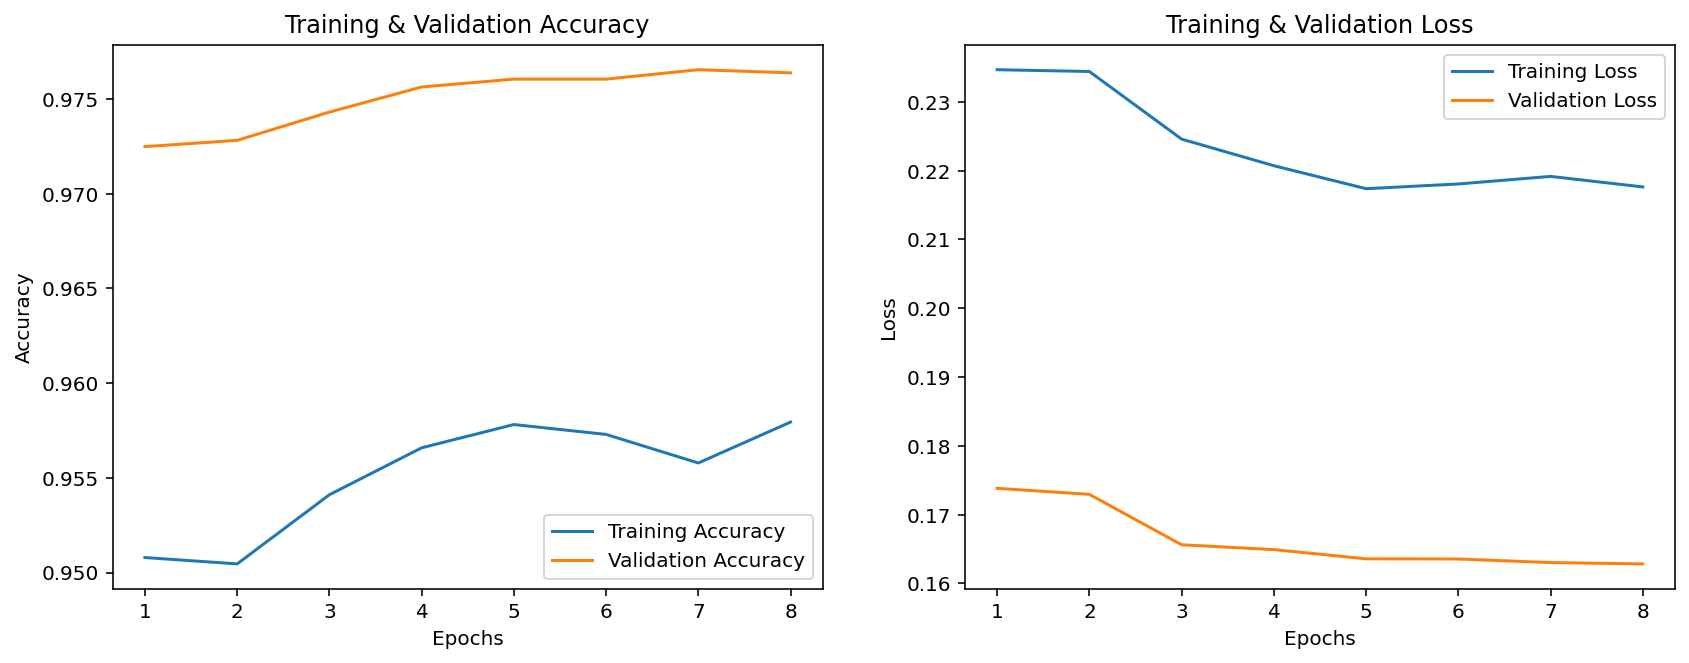

In [129]:
epochs = range(1, len(acc)+1)

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(epochs, acc_vit, label='Training Accuracy')
plt.plot(epochs, val_acc_vit, label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss_vit, label='Training Loss')
plt.plot(epochs, val_loss_vit, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [130]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

85/85 [==============================] - 9s 90ms/step


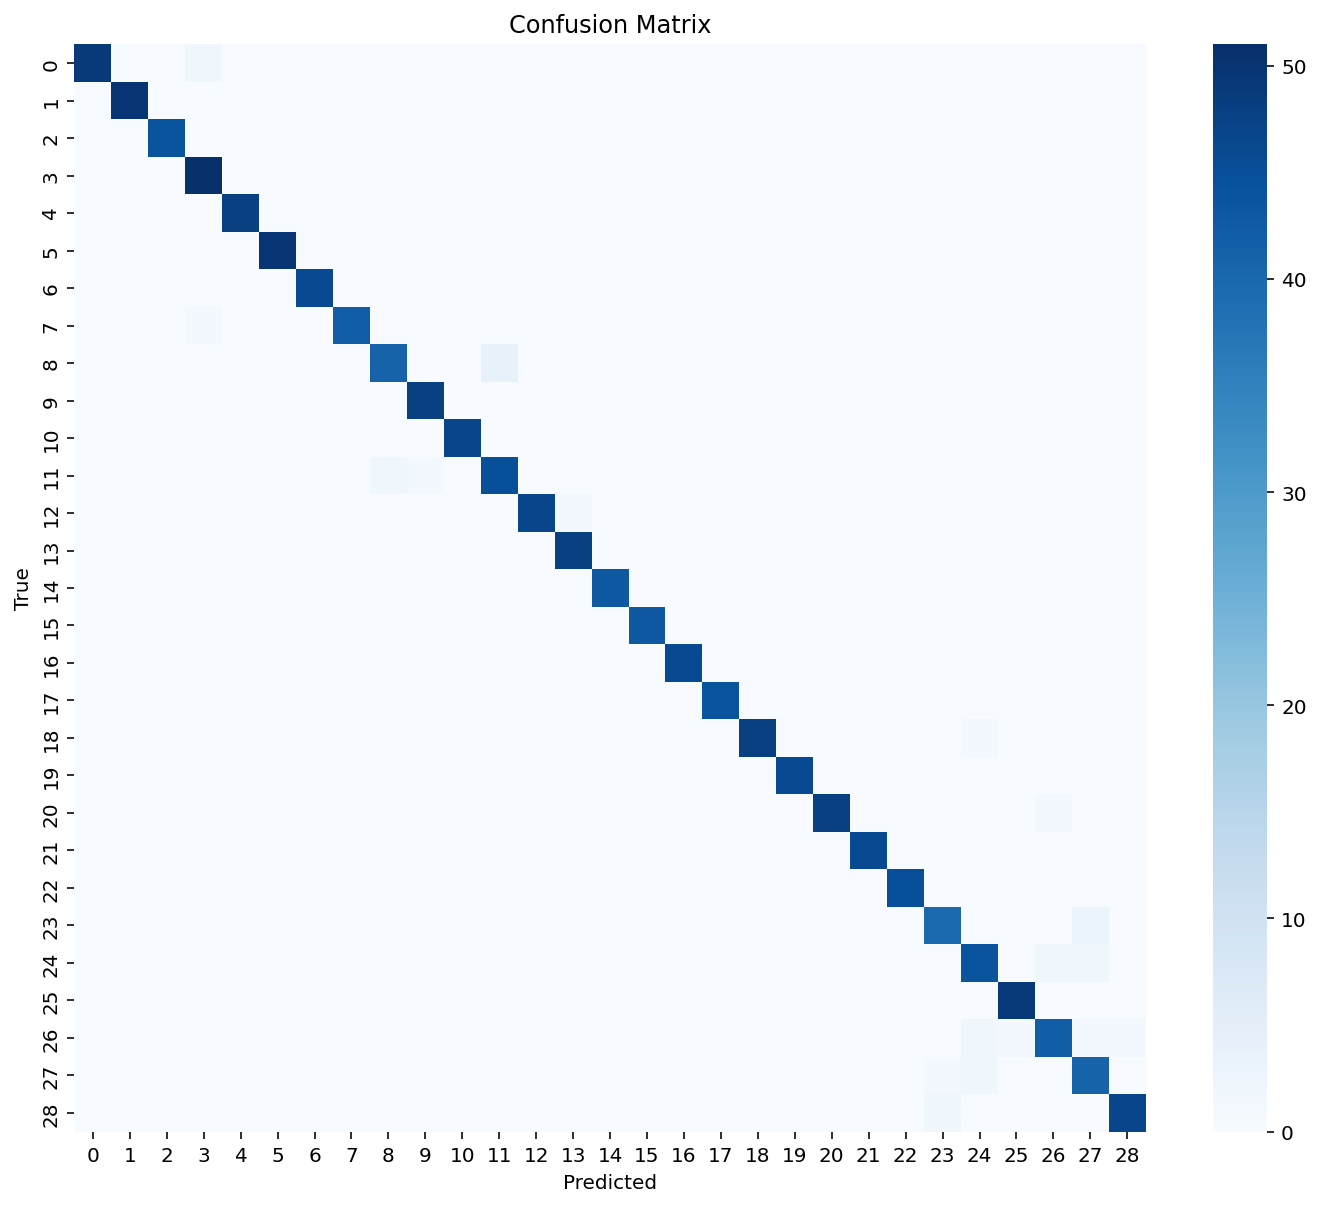

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        51
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        44
           3       0.94      1.00      0.97        51
           4       1.00      1.00      1.00        48
           5       1.00      1.00      1.00        50
           6       1.00      1.00      1.00        46
           7       1.00      0.98      0.99        43
           8       0.95      0.91      0.93        45
           9       0.98      1.00      0.99        48
          10       1.00      1.00      1.00        47
          11       0.92      0.94      0.93        48
          12       1.00      0.98      0.99        48
          13       0.98      1.00      0.99        48
          14       1.00      1.00      1.00        43
          15       1.00      1.00      1.00        43
          16       1.00      1.00      1.00        46
   

In [131]:
y_true_vit = np.concatenate([y for x, y in test_ds], axis=0)
y_true_labels_vit = np.argmax(y_true_vit, axis=1)

y_pred_vit = model.predict(test_ds)
y_pred_labels_vit = np.argmax(y_pred_vit, axis=1)

# Confusion matrix
cm_vit = confusion_matrix(y_true_labels_vit, y_pred_labels_vit)

plt.figure(figsize=(12,10))
sns.heatmap(cm_vit, annot=False, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(y_true_labels_vit, y_pred_labels_vit))

## Failure Analysis of Vision Transformer (ViT)

To gain deeper insights into the Vision Transformer's performance, we will conduct a failure analysis. This involves identifying examples where the model made incorrect predictions and examining the images, true labels, and predicted labels to understand potential patterns of misclassification.

Total misclassified examples: 30


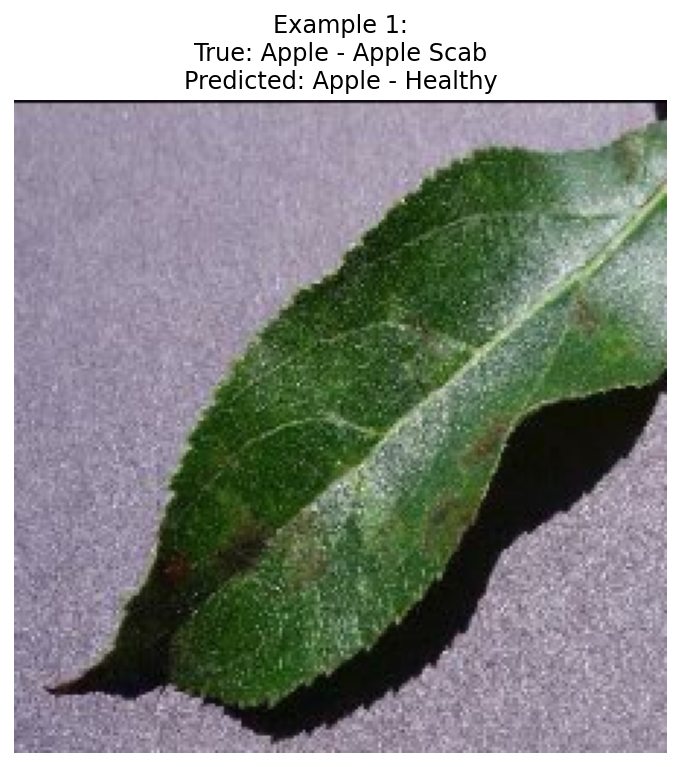

Index in test_ds: 43
True Label: Apple - Apple Scab
Predicted Label: Apple - Healthy
---------------------------------


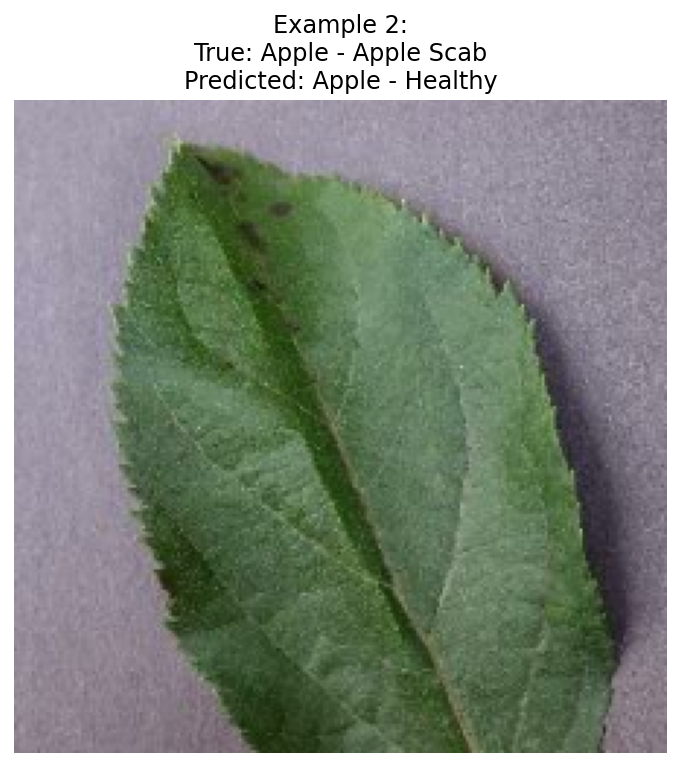

Index in test_ds: 49
True Label: Apple - Apple Scab
Predicted Label: Apple - Healthy
---------------------------------


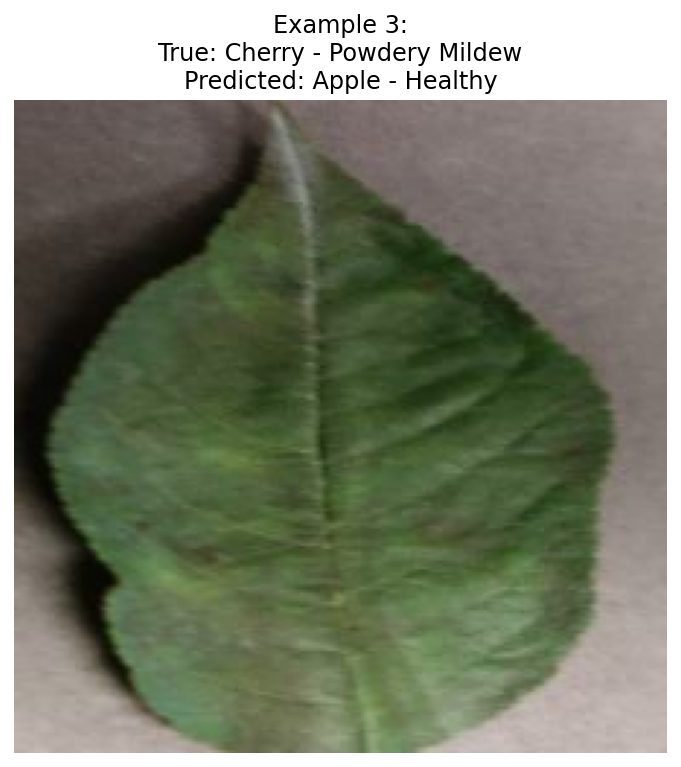

Index in test_ds: 341
True Label: Cherry - Powdery Mildew
Predicted Label: Apple - Healthy
---------------------------------


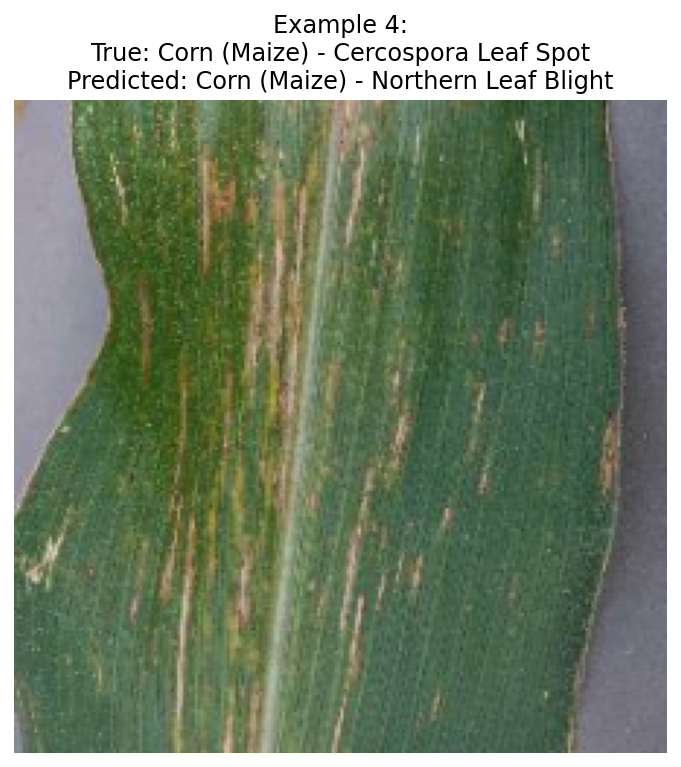

Index in test_ds: 383
True Label: Corn (Maize) - Cercospora Leaf Spot
Predicted Label: Corn (Maize) - Northern Leaf Blight
---------------------------------


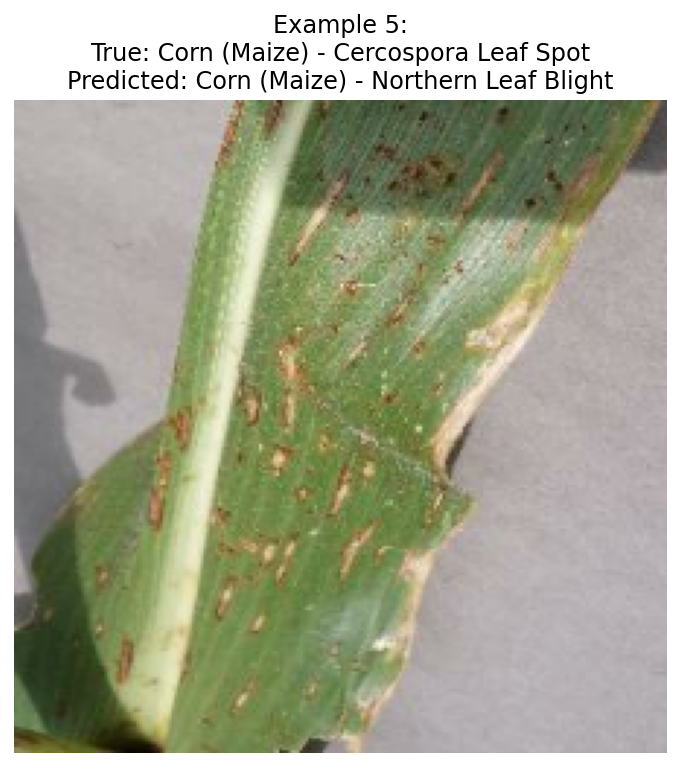

Index in test_ds: 410
True Label: Corn (Maize) - Cercospora Leaf Spot
Predicted Label: Corn (Maize) - Northern Leaf Blight
---------------------------------


In [137]:
import numpy as np
import matplotlib.pyplot as plt

# Collect all images and true labels from the test_ds for easier indexing
all_test_images = []
for images, _ in test_ds:
    all_test_images.append(images.numpy())

all_test_images = np.concatenate(all_test_images)

# Find indices where predictions don't match labels
misclassified_idx = np.where(y_pred_labels_vit != y_true_labels_vit)[0]

print(f"Total misclassified examples: {len(misclassified_idx)}")

# Pick 5 examples to inspect (or fewer if less than 5 are misclassified)
examples_to_show = misclassified_idx[:5]

for i, idx in enumerate(examples_to_show):
    true_label = class_names[y_true_labels_vit[idx]]
    pred_label = class_names[y_pred_labels_vit[idx]]
    image_to_display = all_test_images[idx]

    plt.figure(figsize=(6, 6))
    plt.imshow(image_to_display.astype("uint8")) # Display image as uint8 (0-255 range)
    plt.title(f"Example {i+1}:\nTrue: {true_label}\nPredicted: {pred_label}")
    plt.axis("off")
    plt.show()

    print(f"Index in test_ds: {idx}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {pred_label}")
    print("---------------------------------")

## Overall Model Performance Comparison

Finally, we will visualize and compare the training and validation accuracy and loss curves for all trained models (EfficientNetV2B0, ResNet50V2, MobileNetV3Large, and Vision Transformer).


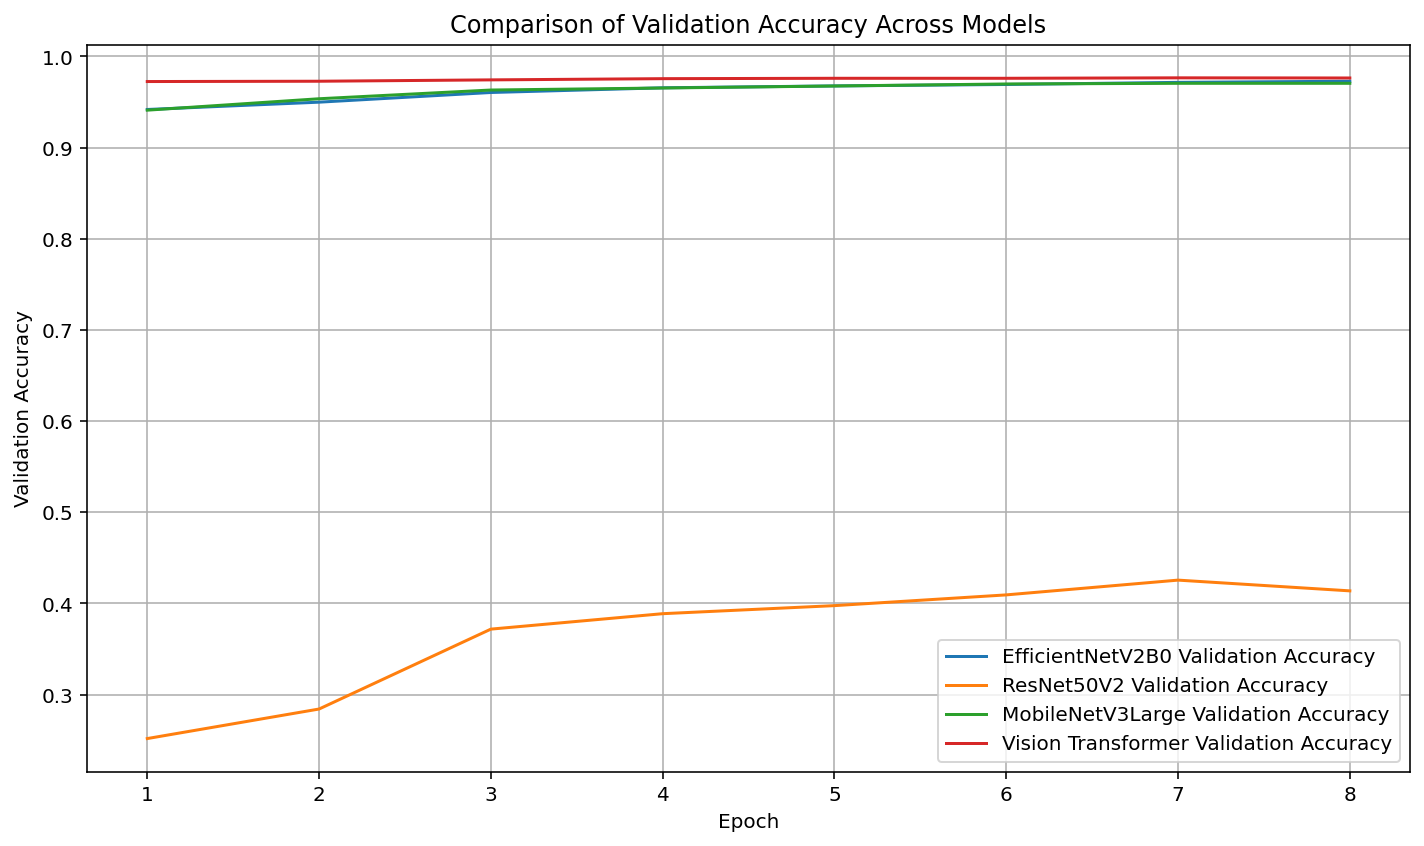

In [135]:
# Determine the total number of epochs (all models trained for 2 + 6 = 8 epochs)
epochs = range(1, len(val_accuracy_effnet) + 1)

# Create a new figure and an axes object
plt.figure(figsize=(10, 6))

# Plot the validation accuracy for each model
plt.plot(epochs, val_accuracy_effnet, label='EfficientNetV2B0 Validation Accuracy')
plt.plot(epochs, val_accuracy_resnet, label='ResNet50V2 Validation Accuracy')
plt.plot(epochs, val_accuracy_mobilenet, label='MobileNetV3Large Validation Accuracy')
plt.plot(epochs, val_acc_vit, label='Vision Transformer Validation Accuracy')

# Add title, labels, and legend
plt.title('Comparison of Validation Accuracy Across Models')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)

# Ensure all elements fit within the figure
plt.tight_layout()

# Display the plot
plt.show()

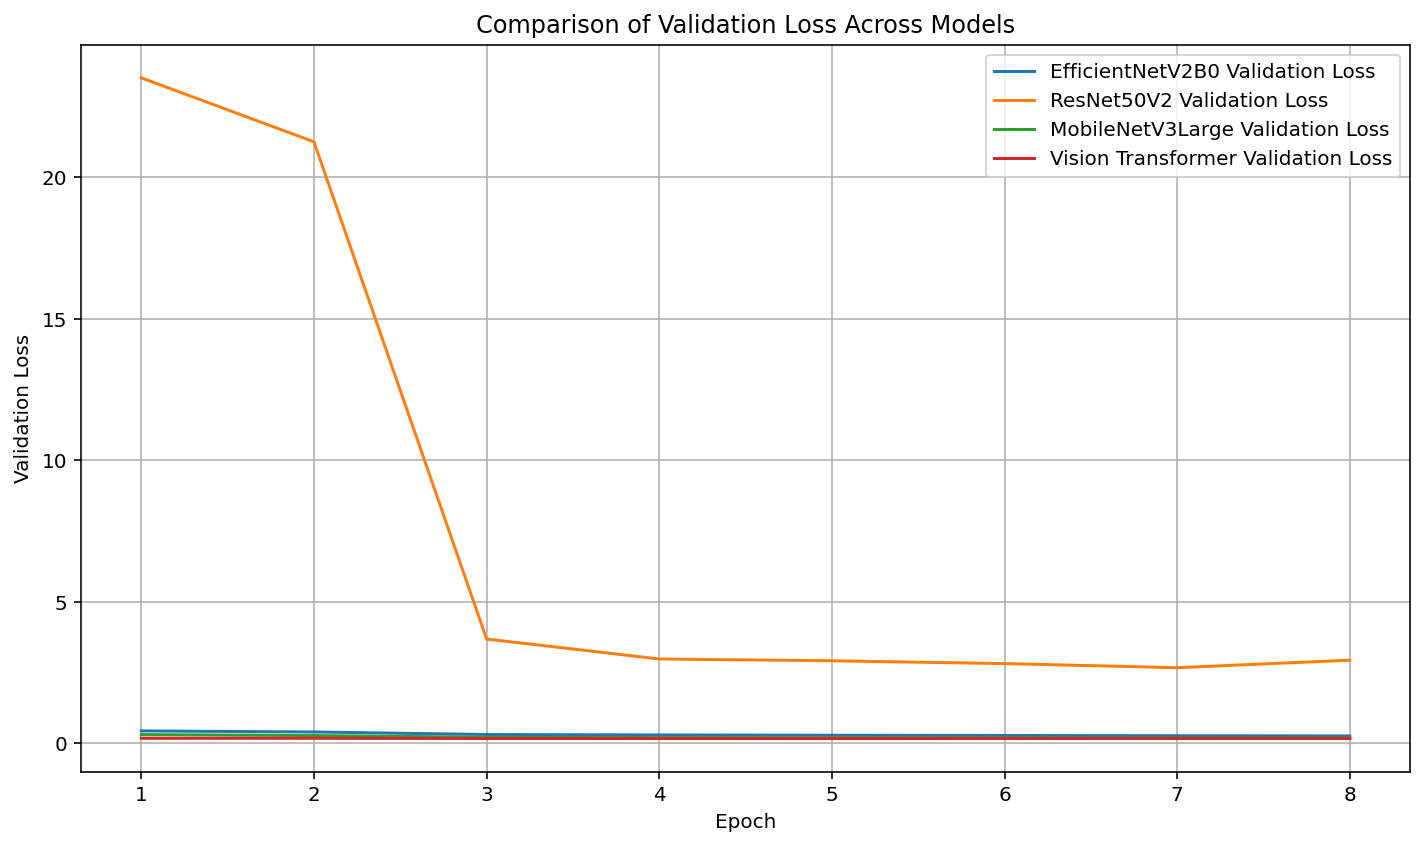

In [136]:
# Determine the total number of epochs (all models trained for 2 + 6 = 8 epochs)
epochs = range(1, len(val_loss_effnet) + 1)

# Create a new figure and an axes object
plt.figure(figsize=(10, 6))

# Plot the validation loss for each model
plt.plot(epochs, val_loss_effnet, label='EfficientNetV2B0 Validation Loss')
plt.plot(epochs, val_loss_resnet, label='ResNet50V2 Validation Loss')
plt.plot(epochs, val_loss_mobilenet, label='MobileNetV3Large Validation Loss')
plt.plot(epochs, val_loss_vit, label='Vision Transformer Validation Loss')

# Add title, labels, and legend
plt.title('Comparison of Validation Loss Across Models')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)

# Ensure all elements fit within the figure
plt.tight_layout()

# Display the plot
plt.show()
